In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

np.random.seed(881)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN


import os
import wget
from pathlib import Path
import shutil
import gzip
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ROOT_DIR = "Data"
RANDOM_STATE = 881

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [3]:
df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

normal_ratio = 14.5  # 1.0 means 1:1 ratio
# normal_ratio = 1.0  # 1.0 means 1:1 ratio
df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
Normal      34075
AbNormal     2350
dtype: int64

In [4]:
RANDON_STATE=881

In [5]:
train = df_concat

In [6]:
# Train, val and test split follows
n_total = len(train)
train_indices, valid_indices = train_test_split(
    range(n_total), test_size=0.3, random_state=RANDON_STATE)

In [7]:
#Preprocessing
def simplepreprocessing(df):
    #categorical feature의 레이블 인코딩
    categorical_columns = []
    categorical_dims =  {} #각 범주형 feature의 인코딩된 클래스 수 저장 
    for col in df.columns[df.dtypes == object]:
#         print(col, df[col].nunique()) #컬럼의 이름과 고유 값의 개수를 출력
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

    #numerical feature의 결측치 채우기 
    for col in df.columns[df.dtypes == 'float64']:
        df.fillna(train.loc[train_indices, col].mean(), inplace=True)
    return categorical_columns, categorical_dims, df

In [8]:
categorical_columns, categorical_dims, train = simplepreprocessing(train)
_, _, test = simplepreprocessing(test)

In [9]:
test = test.drop(columns=['Set ID'])

In [10]:
#define categorical features for categorical embeddings
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+['target']] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [11]:
#network 정의 
clf = TabNetClassifier(
    n_d=8, n_a=8, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.02, clip_value=2.,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=5e-2),
    scheduler_params = {"T_max": 10,
                     "eta_min": 0},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingLR, epsilon=1e-15
)

/home/work/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [12]:
X_train = train[features].values[train_indices]
y_train = train['target'].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train['target'].values[valid_indices]

X_test = test[features]

In [13]:
max_epochs = 200

In [14]:
# # SMOTE와 Tomek Links 결합
# resampler = SMOTETomek(random_state=RANDOM_STATE)

# # 파이프라인을 통해 데이터 샘플링
# pipeline = Pipeline(steps=[('resampler', resampler)])
# train_x_resampled, train_y_resampled = pipeline.fit_resample(X_train, y_train)

# # 결과 확인
# print(f"Original dataset shape: {Counter(y_train)}")
# print(f"Resampled dataset shape: {Counter(train_y_resampled)}")

In [15]:
# # SMOTEENN 생성
# smote_enn = SMOTEENN(random_state=RANDOM_STATE)

# # 파이프라인을 통해 데이터 샘플링
# pipeline = Pipeline(steps=[('resampler', smote_enn)])
# train_x_resampled, train_y_resampled = pipeline.fit_resample(X_train, y_train)

# # 결과 확인
# print(f"Original dataset shape: {Counter(y_train)}")
# print(f"Resampled dataset shape: {Counter(train_y_resampled)}")

In [16]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=1024, virtual_batch_size=256
) 

epoch 0  | loss: 0.32477 | train_auc: 0.50634 | valid_auc: 0.50645 |  0:00:04s
epoch 1  | loss: 0.24577 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:07s
epoch 2  | loss: 0.24168 | train_auc: 0.50751 | valid_auc: 0.50055 |  0:00:10s
epoch 3  | loss: 0.2407  | train_auc: 0.55741 | valid_auc: 0.54754 |  0:00:12s
epoch 4  | loss: 0.23973 | train_auc: 0.54635 | valid_auc: 0.53844 |  0:00:15s
epoch 5  | loss: 0.24372 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:18s
epoch 6  | loss: 0.24319 | train_auc: 0.50876 | valid_auc: 0.50413 |  0:00:21s
epoch 7  | loss: 0.23834 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:24s
epoch 8  | loss: 0.2393  | train_auc: 0.5     | valid_auc: 0.5     |  0:00:27s
epoch 9  | loss: 0.237   | train_auc: 0.5     | valid_auc: 0.5     |  0:00:30s
epoch 10 | loss: 0.23992 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:33s
epoch 11 | loss: 0.23926 | train_auc: 0.5     | valid_auc: 0.5     |  0:00:36s
epoch 12 | loss: 0.24038 | train_auc: 0.5     | vali

/home/work/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [17]:
# 검증 데이터에 대한 예측 수행
y_valid_pred = clf.predict(X_valid)

# F1-score 계산
valid_f1 = f1_score(y_valid, y_valid_pred, average='macro')  # or 'macro', 'micro' depending on your specific needs

# F1-score 출력
print(f"Validation F1-score: {valid_f1:.4f}")

Validation F1-score: 0.4870


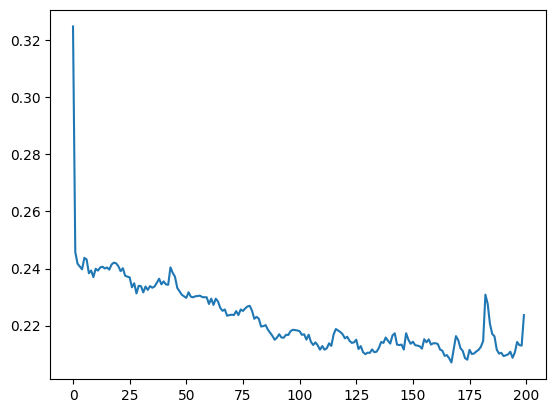

In [18]:
# plot losses
plt.plot(clf.history['loss'])

In [19]:
X_test_array = X_test.values
y_pred = clf.predict(X_test_array)
y_pred_series = pd.Series(y_pred)
y_pred_labels = y_pred_series.map({1: 'Normal', 0: 'AbNormal'})
print(y_pred_labels.head())
print()
print(y_pred_labels.tail())

0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
dtype: object

17356    Normal
17357    Normal
17358    Normal
17359    Normal
17360    Normal
dtype: object


In [20]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [21]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/home/work/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [22]:
X_test_array = X_test.values
loaded_preds = loaded_clf.predict(X_test_array)
y_pred_series = pd.Series(y_pred)
y_pred_labels = y_pred_series.map({1: 'Normal', 0: 'AbNormal'})

In [23]:
# 제출 파일 작성
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred_labels
df_sub.to_csv("submission.csv", index=False)